In [1]:
import ants
import nilearn
from nilearn import image
import os
import shutil
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nilearn.image import load_img
from nilearn.image import math_img
from nilearn.image import resample_to_img
from nipype.interfaces.ants import ApplyTransforms
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [2]:
#load, check for voxel dimensions, resample: lukas stns
directory = [i for i in os.listdir('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS') if i.startswith('sub-BER00') or i.startswith('sub-BER01') or i.startswith('sub-BER021')or i.startswith('sub-BER022') or i.startswith('sub-BER023') or i.startswith('sub-BER024') or i.startswith('sub-BER025')]

def dim(path):
    return nib.load(path).header.get_zooms()

def resample_binarize(sub,stn,output_path):
    sub = load_img(sub)
    stn = load_img(stn)
    re_sub = resample_to_img(sub,stn,interpolation='nearest')
    nib.save(re_sub,output_path)
    
def check4dims(sub_vox,stn_vox,sub,stn,output_path):
    if sub_vox == stn_vox:
        print('voxel dimensions the same')
    else:
        resample_binarize(sub,stn,output_path)

stn_mni_lh = '/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/HotspotsAtlas/resampled/STN_lh.nii.gz'
stn_mni_vox_lh = dim(stn_mni_lh)
stn_mni_rh = '/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/HotspotsAtlas/resampled/STN_rh.nii.gz'
stn_mni_vox_rh = dim(stn_mni_rh)

for i in directory:
    #load in native stn for resampling anchor
    stn_native = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/STNs/segmentationsLukas0-25/{i}.nii'
    stn_native_vox = dim(stn_native)
    
    #load in patients
    native_lh = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/stimulations/native/gs_/{i}_sim-binary_model-ossdbs_hemi-L.nii'
    native_rh = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/stimulations/native/gs_/{i}_sim-binary_model-ossdbs_hemi-R.nii'
  
    native_lh_sub,native_rh_sub = load_img(native_lh),load_img(native_rh)
    
    native_lh_vox,native_rh_vox = dim(native_lh),dim(native_rh)
    
    check4dims(native_lh_vox,stn_native_vox,native_lh_sub,stn_native,f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-L.nii')
    check4dims(native_rh_vox,stn_native_vox,native_rh_sub,stn_native,f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-R.nii')

In [4]:
#get volume of overlaps
directory = [i for i in os.listdir('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS') if i.startswith('sub-BER020')]
regions = ['STN','pd_stn_n275_hotspot']

#create dictionaries to store results
sub_ids = {'IDs': []}
native_overlap = {f'{r}_Native_Overlap_LH': [] for r in regions}
native_overlap.update({f'{r}_Native_Overlap_RH': [] for r in regions})
native_bilateral_overlap = {f'{r}_Native_Overlap_BI': [] for r in regions}
native_vox_dims = {f'{r}_Native_Voxel_Dimensions': [] for r in regions}
native_bilateral_mm = {f'{r}_Native_Overlap_BI_MM': [] for r in regions}
    
def get_binary_overlap(roi,sub,volume_list):
    mask = math_img('img1*img2',img1=roi,img2=sub)
    mask = mask.get_fdata()
    volume = np.sum(mask)
    volume_list.append(volume)
    
def binary_bilateral(list1,list2,sums_list):
    sums = [(x + y) for x, y in zip(list1, list2)]
    sums_list.extend(sums)
    
def vox_dims(sub, vox_list):
    vox = sub.header.get_zooms()
    voxel_volume = vox[0] * vox[1] * vox[2]
    vox_list.append(voxel_volume)
    
def convert(bi_list, vox_list):
    return [bi * vox for bi, vox in zip(bi_list, vox_list)]

for i in directory:
    print(i)
    sub_ids['IDs'].append(i)
    
    for r in regions:
        roi_native = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/STNs/segmentationsLukas0-25/{i}.nii')
        
        sub_native_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-L.nii')
        sub_native_rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-R.nii')
        
        get_binary_overlap(roi_native,sub_native_lh,native_overlap[f'{r}_Native_Overlap_LH'])
        get_binary_overlap(roi_native,sub_native_rh,native_overlap[f'{r}_Native_Overlap_RH'])
        
for r in regions:
    binary_bilateral(native_overlap[f'{r}_Native_Overlap_LH'], native_overlap[f'{r}_Native_Overlap_RH'], native_bilateral_overlap[f'{r}_Native_Overlap_BI'])

for i in directory:
    for r in regions:
        sub_native_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-L.nii')
        vox_dims(sub_native_lh,native_vox_dims[f'{r}_Native_Voxel_Dimensions']) 
        native_bilateral_mm[f'{r}_Native_Overlap_BI_MM'] = convert(native_bilateral_overlap[f'{r}_Native_Overlap_BI'], native_vox_dims[f'{r}_Native_Voxel_Dimensions'])

ids_df = pd.DataFrame.from_dict(sub_ids, orient='index').transpose()
native_df = pd.DataFrame.from_dict(native_overlap, orient='index').transpose()
native_bilateral_df = pd.DataFrame.from_dict(native_bilateral_overlap, orient='index').transpose()
native_vox_df = pd.DataFrame.from_dict(native_vox_dims,orient='index').transpose()
native_bilateral_mm_df = pd.DataFrame.from_dict(native_bilateral_mm, orient='index').transpose()

combined_df = pd.concat([ids_df,native_df, native_bilateral_df, native_vox_df,native_bilateral_mm_df], axis=1, keys=['IDs','Native', 'Native_Bilateral', 'Native_Vox','Native_Bilateral_MM'])

combined_df.to_csv('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS_Lukas_20Volume_Overlaps_STN_Native.csv', index=False)

sub-BER020


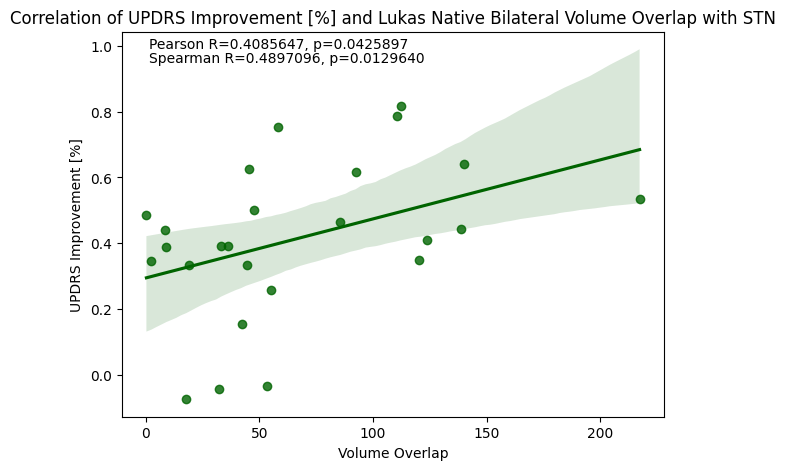

In [6]:
#oss-dbs
df = pd.read_csv('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS_Lukas_Volume_Overlaps_STN_Native.csv')
regions = ['STN']

def r_p(vol_overlap_col):
    pearson_r, pearson_p = pearsonr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    spearman_r, spearman_p = spearmanr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    return pearson_r, pearson_p, spearman_r, spearman_p

def plot_analysis(x_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=df['UPDRS_Improvement_Perc'], color=color)
    plt.title(title)
    plt.xlabel('Volume Overlap')
    plt.ylabel('UPDRS Improvement [%]')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),transform=ax.transAxes, verticalalignment='top')
    plt.savefig(path)
    plt.show()
    
for r in regions:
    native_pearson_r,native_pearson_p,native_spearman_r,native_spearman_p = r_p(f'{r}_Native_Overlap_BI_MM')
    plot_analysis(df[f'{r}_Native_Overlap_BI_MM'],f'Correlation of UPDRS Improvement [%] and Lukas Native Bilateral Volume Overlap with {r}',native_pearson_r,native_pearson_p,native_spearman_r,native_spearman_p,'darkgreen',f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/Figures/OSS-DBS/Lukas Native Correlation Bilateral Volume Overlap with {r}.png')